<a href="https://colab.research.google.com/github/ccg-esb/MI/blob/main/MI_1_RegulatoryModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook introduces a regulatory model to study mRNA and protein dynamics influenced by upstream translation-dependent mRNA stability. It defines a system of differential equations (ODEs) for mRNA and protein synthesis and degradation, incorporating the protective effect of ribosomes on mRNA stability. The model is parameterized and solved numerically to understand gene expression regulation in synthetic and natural systems.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from itertools import permutations
from scipy.integrate import odeint
from itertools import product
import pandas as pd
import gspread
from gspread_dataframe import get_as_dataframe
from google.colab import auth
from google.auth import default
import pickle
from google.colab import drive
import os

In [ ]:

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define the base path in Google Drive and a subdirectory for parameters
base_path = '/content/drive/My Drive/SYNC_Projects/MI/'  #
pathPARAMS = os.path.join(base_path, 'data/')
dirNameData = os.path.join(pathPARAMS, f"X_GC1_GC2")
os.makedirs(dirNameData, exist_ok=True)

pathFIGURES = os.path.join(base_path, 'figures/')
dirNameFigures = os.path.join(pathFIGURES, f"X_GC1_GC2")
os.makedirs(dirNameFigures, exist_ok=True)

expe_label=f"X_GC1_GC2_k{int(test_k_value*100)}e-2"
file_name_figures = f"{dirNameFigures}/{expe_label}"

Mounted at /content/drive


### Modeling mRNA and Protein Dynamics with Upstream Translation-Dependent mRNA Stability

To model the dynamics of mRNA and protein concentrations in this system, using $m_i$ for the concentration of mRNA of gene $i$ and $p_i$ for the concentration of the corresponding protein, the ODEs are defined as follows:

#### 1. mRNA Dynamics ($m_i$):
The rate of change in the concentration of mRNA for gene $i$ can be expressed as:

$$
\frac{dm_i}{dt} = \alpha_i - D_i(T_{i-1}; k_{i-1}) \cdot m_i
$$

Where:

- $\alpha_i$ is the transcription rate of mRNA from gene $i$. This is typically a constant rate assuming no direct transcriptional regulation by proteins.
- $D_i(T_{i-1}; k_{i-1})$ is the degradation rate of mRNA from gene $i$, which depends on the concentration of mRNA itself ($m_i$) and the translation rate of the upstream gene ($T_{i-1}$). This function decreases as $T_{i-1}$ (translation of the upstream gene) increases.

#### 2. Protein Dynamics ($p_i$):
The rate of change in the concentration of protein $i$ can be expressed as:

$$
\frac{dp_i}{dt} = \beta_i \cdot m_i - \delta_i \cdot p_i
$$

Where:

- $\beta_i$ is the translation rate of mRNA $m_i$ into protein $p_i$. This is usually proportional to $m_i$, assuming sufficient ribosome availability.
- $\delta_i$ is the degradation rate of the protein. For simplicity, this can be modeled as a constant rate.

Note that the function $D_i(T_{i-1}; k_{i-1})$ models the mRNA degradation rate as a function of the upstream gene's translation rate:

$$
D_i(T_{i-1}; k_{i-1}) = \frac{d_{\text{base}}[i]}{k_{i-1} \cdot T_{i-1}}
$$

Where:

- $d_{\text{base}}[i]$ is the baseline degradation rate of the mRNA if no ribosome protection occurs.
- $k_{i-1}$ is a constant that scales the effect of translation on degradation. This ensures that as $T_{i-1}$ (translation rate of gene $i-1$) increases, $D_i$ decreases, reflecting the protective effect of ribosomes.

### System of ODEs

Altogether, the ODEs for each gene $i$ are:

**mRNA ODE:**

$$
\frac{dm_i}{dt} = \alpha_i - \frac{d_{\text{base}}[i] }{ k_{i-1}\cdot T_{i-1}}\cdot m_i
$$

**Protein ODE:**

$$
\frac{dp_i}{dt} = \beta_i \cdot m_i - \delta_i \cdot p_i
$$


In [ ]:
test_k_value=0.5
base_k_value=0.4
num_genes = 3

alpha = [0.5] * num_genes   # Transcription rates (mRNA molecules per minute, moderate promoter strength)
beta = [1.8] * num_genes    # Translation rates (proteins per mRNA per minute)
delta = [0.6] * num_genes  # Protein degradation rates (moderately stable proteins)
d_base = [0.5] * num_genes  # Baseline mRNA degradation rates (short mRNA half-lives)

k_values = [base_k_value] * num_genes  # Gene-specific scaling constants for the translation effect

k_values[0]=test_k_value

m_initial = [0.01] * num_genes  # Initial mRNA concentrations
p_initial = [0.0] * num_genes  # Initial protein concentrations
t = np.linspace(0, 100, 100)  # Time array

In [ ]:

from scipy.integrate import odeint
import numpy as np

def runODE(num_genes, alpha, beta, delta, d_base, k_values, m_initial, p_initial, t):
    """
    Simulates the ODEs for mRNA and protein dynamics for a given number of genes, each with its own k value.

    Parameters:
        num_genes (int): Number of genes in the system.
        alpha (list): Transcription rates for each gene.
        beta (list): Translation rates for each gene.
        delta (list): Protein degradation rates for each gene.
        d_base (list): Baseline mRNA degradation rates for each gene.
        k_values (list): Scaling constants for the translation effect for each gene.
        m_initial (list): Initial mRNA concentrations for each gene.
        p_initial (list): Initial protein concentrations for each gene.
        t (array): Time array for simulation.

    Returns:
        sol (array): Solution array with mRNA and protein concentrations over time.
    """
    def model(y, t, alpha, beta, delta, d_base, k_values, num_genes):
        # Split y into mRNA and protein concentrations
        m = y[:num_genes]
        p = y[num_genes:]

        # Derivatives
        dm_dt = np.zeros(num_genes)
        dp_dt = np.zeros(num_genes)

        # Calculate translation rates based on current mRNA concentrations
        T = beta * m  # Translation rate is proportional to mRNA concentration

        for i in range(num_genes):
            if i == 0:
                # No upstream protection for the first gene
                degradation_rate = d_base[i]
            else:
                # For subsequent genes, apply upstream protection effect
                upstream_translation = T[i-1]
                degradation_rate = d_base[i] / (k_values[i-1] * upstream_translation)
                #print(k_values[i-1], d_base[i], degradation_rate)

            # ODE for mRNA concentration
            dm_dt[i] = alpha[i] - degradation_rate * m[i]

            # ODE for protein concentration using T[i]
            dp_dt[i] = T[i] - delta[i] * p[i]

        return np.concatenate([dm_dt, dp_dt])

    # Initial conditions
    y0 = np.concatenate([m_initial, p_initial])

    # Solve ODEs
    sol = odeint(model, y0, t, args=(alpha, beta, delta, d_base, k_values, num_genes))

    return sol


    # Initial conditions
    y0 = np.concatenate([m_initial, p_initial])

    # Solve ODEs
    sol = odeint(model, y0, t, args=(alpha, beta, delta, d_base, k_values, num_genes))

    return sol


# Run simulation
sol = runODE(num_genes, alpha, beta, delta, d_base, k_values, m_initial, p_initial, t)


Exporting /content/drive/My Drive/SYNC_Projects/MI/figures/X_GC1_GC2/X_GC1_GC2_k50e-2_ODE.pdf


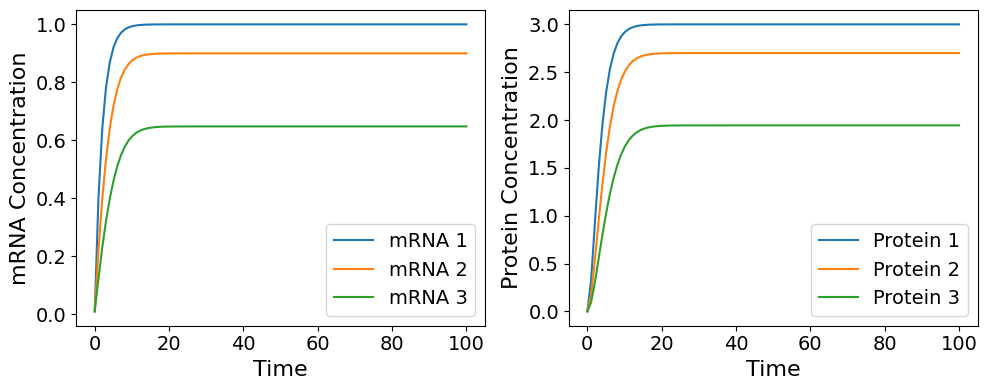

In [ ]:

def plotODE(t, sol, num_genes, outPath=''):
    """
    Plots the mRNA and protein concentrations over time for all genes in a single plot for comparison.

    Parameters:
        t (array): Time array for the simulation.
        sol (array): Solution array from runODE.
        num_genes (int): Number of genes in the system.
    """
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Plot all mRNA concentrations on the left
    for i in range(num_genes):
        axs[0].plot(t, sol[:, i], label=f'mRNA {i+1}')

    axs[0].set_xlabel('Time', fontsize=16)
    axs[0].set_ylabel('mRNA Concentration', fontsize=16)
    axs[0].legend(fontsize=14,loc='lower right')
    axs[0].tick_params(axis='x', labelsize=14)
    axs[0].tick_params(axis='y', labelsize=14)


    # Plot all protein concentrations on the right
    for i in range(num_genes):
        axs[1].plot(t, sol[:, num_genes + i], label=f'Protein {i+1}')

    axs[1].set_xlabel('Time', fontsize=16)
    axs[1].set_ylabel('Protein Concentration', fontsize=16)
    axs[1].legend(fontsize=14,loc='lower right')
    axs[1].tick_params(axis='x', labelsize=14)
    axs[1].tick_params(axis='y', labelsize=14)



    plt.tight_layout()

    # Save or show plot
    if outPath:
        filename = f"{outPath}_ODE.pdf"
        plt.savefig(filename, format='pdf')
        print(f"Exporting {filename}")
        plt.show()
        plt.close()
    else:
        plt.show()


# Plot results
plotODE(t, sol, num_genes, file_name_figures)


Exporting /content/drive/My Drive/SYNC_Projects/MI/figures/X_GC1_GC2/X_GC1_GC2_k50e-2_FinalProtein.pdf


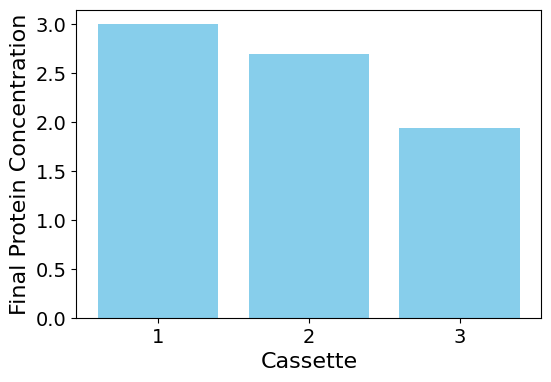

In [ ]:
def plotProteinEndpoints(sol, num_genes, outPath=''):
    """
    Produces a bar plot of the final protein concentrations for all genes.

    Parameters:
        sol (array): Solution array from runODE.
        num_genes (int): Number of genes in the system.
    """
    # Extract final protein concentrations (last row in the solution array)
    final_protein_concentrations = sol[-1, num_genes:]  # Proteins are in the second half of the solution array

    # Gene labels for the bar plot
    gene_labels = [f'{i+1}' for i in range(num_genes)]

    # Create the bar plot
    plt.figure(figsize=(6, 4))
    plt.bar(gene_labels, final_protein_concentrations, color='skyblue')

    # Add labels and title
    plt.xlabel('Cassette', fontsize=16)
    plt.ylabel('Final Protein Concentration', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Save or show plot
    if outPath:
        filename = f"{outPath}_FinalProtein.pdf"
        plt.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0.2)
        print(f"Exporting {filename}")
        plt.show()
        plt.close()
    else:
        plt.show()

# Example usage

plotProteinEndpoints(sol, num_genes, file_name_figures)




The parameter $k$ in the model captures the **protective effect** of translation on mRNA degradation. Specifically, it quantifies how much the translation of an upstream gene (via ribosome binding) influences the stability of the downstream mRNA. The degradation rate of an mRNA is adjusted based on the upstream translation activity and is given by:

$$
\text{Degradation Rate} = \frac{d_{\text{base}}[i]}{ k_{i-1} \cdot T[i-1]}
$$

Where:
- $d_{\text{base}}[i]$ is the baseline degradation rate of mRNA from gene $i$.
- $T[i-1]$ is the translation rate of the upstream gene.
- $k_{i-1}$ is the scaling factor that modulates how much upstream translation protects downstream mRNA from degradation.

### How $k$ Drives Polarity

1. **Low $k$**: When $k$ is low, the influence of upstream translation on downstream mRNA stability is minimal. As a result, downstream genes are degraded more rapidly, leading to **classic polarity**, where upstream genes are expressed at higher levels than downstream ones.

2. **High $k$**: When $k$ is high, the degradation rate of downstream mRNA is significantly reduced if the upstream gene is translated efficiently. This allows downstream mRNAs to accumulate to higher levels, potentially reversing the polarity effect, with downstream genes being expressed at higher levels than upstream genes.

3. **Intermediate $k$**: At intermediate values, $k$ provides a balanced protective effect, allowing for moderate stabilization of downstream mRNAs without completely negating polarity. This may reflect a realistic bacterial scenario where downstream genes are expressed but still at lower levels than upstream genes.



[0.1, 0.1, 0.1] [3.     0.54   0.0972]
[0.13157894736842107, 0.13157894736842107, 0.13157894736842107] [3.         0.71052632 0.16828255]
[0.1631578947368421, 0.1631578947368421, 0.1631578947368421] [3.         0.88105263 0.25875125]
[0.19473684210526315, 0.19473684210526315, 0.19473684210526315] [3.         1.05157895 0.36860609]
[0.22631578947368422, 0.22631578947368422, 0.22631578947368422] [3.         1.22210526 0.49784709]
[0.2578947368421053, 0.2578947368421053, 0.2578947368421053] [3.         1.39263158 0.64647424]
[0.2894736842105263, 0.2894736842105263, 0.2894736842105263] [3.         1.56315789 0.81448753]
[0.32105263157894737, 0.32105263157894737, 0.32105263157894737] [3.         1.73368421 1.00188698]
[0.3526315789473684, 0.3526315789473684, 0.3526315789473684] [3.         1.90421053 1.20867258]
[0.38421052631578945, 0.38421052631578945, 0.38421052631578945] [3.         2.07473684 1.43484432]
[0.4157894736842105, 0.4157894736842105, 0.4157894736842105] [3.         2.2452631

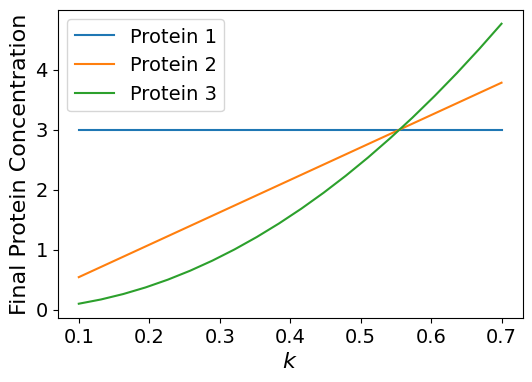

5.555555556162305
0.7936507936505294


In [ ]:
def plotKvProtein(k_values, endpoint_proteins, outPath=''):
    """
    Produces a plot of the final protein concentrations for all genes across different k values.

    Parameters:
        k_values (array): Array of k values tested.
        endpoint_proteins (array): Array of final protein concentrations for each k value.
    """
    plt.figure(figsize=(6, 4))
    for i in range(endpoint_proteins.shape[1]):
        plt.plot(k_values, endpoint_proteins[:, i], label=f'Protein {i+1}')

    plt.xlabel(r'$k$', fontsize=16)
    plt.ylabel('Final Protein Concentration', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(False)


    # Save or show plot
    if outPath:
        filename = f"{outPath}KvProtein.pdf"
        plt.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0.2)
        print(f"Exporting {filename}")
        plt.show()
        plt.close()
    else:
        plt.show()


# Array to store final protein concentrations for different k values
k_range = np.linspace(0.1, 0.7, 20)  # Range of k values to test
endpoint_proteins = np.zeros((len(k_range), num_genes))


# Run simulations over different k values
for idx, k in enumerate(k_range):
    k_list = [k] * num_genes  # Create a list of the same k value for all genes
    #k_list[-1]=k_gfp

    sol = runODE(num_genes, alpha, beta, delta, d_base, k_list, m_initial, p_initial, t)
    endpoint_proteins[idx, :] = sol[-1, num_genes:]  # Store final protein concentrations
    print(k_list,sol[-1, num_genes:])

# Plot results
plotKvProtein(k_range, endpoint_proteins, "%s/"%dirNameFigures)

print(endpoint_proteins[0,0]/endpoint_proteins[0,1])
print(endpoint_proteins[-1,0]/endpoint_proteins[-1,1])


In [ ]:
print(k_values)

[0.5, 0.4, 0.4]


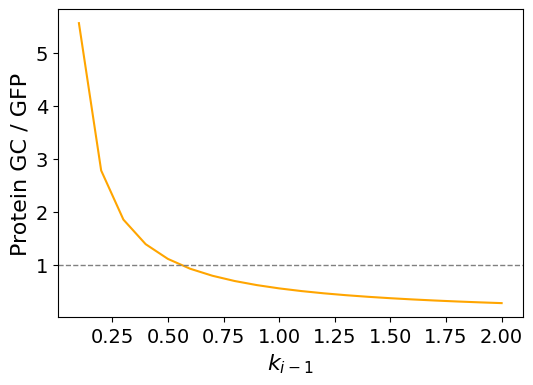

In [ ]:

# Define the range of k values to test
protein_ratios = []  # To store Protein 2 / Protein 1 ratios

# Run simulations over different k values
for k in k_range:
    # Set up k values for GC and GFP with GC varying

    k_list = [k, k]  # Assume k_GFP = 0.4 as a fixed value for comparison
    sol = runODE(num_genes=2, alpha=alpha[:2], beta=beta[:2], delta=delta[:2],
                 d_base=d_base[:2], k_values=k_list,
                 m_initial=m_initial[:2], p_initial=p_initial[:2], t=t)

    # Calculate the ratio of Protein 2 to Protein 1 at the final time point
    final_protein1 = sol[-1, 2]  # Final concentration of Protein 1
    final_protein2 = sol[-1, 3]  # Final concentration of Protein 2
    protein_ratio = final_protein1  / final_protein2
    protein_ratios.append(protein_ratio)

# Plot the ratio of Protein 2 to Protein 1 across the range of k values
plt.figure(figsize=(6, 4))
plt.plot(k_range, protein_ratios, color='orange')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.xlabel(r'$k_{i-1}$', fontsize=16)
plt.ylabel('Protein GC / GFP', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
plt.show()


In [ ]:

# Function to run the experiment for a given permutation of genes
def run_experiment(gene_order, k_values):
    # Adjust k_values to match the length of gene_order
    reordered_k_values = [k_values[gene_order[i]] for i in range(len(gene_order))]
    while len(reordered_k_values) < num_genes:
        reordered_k_values.append(k_values[2])  # Fill with the k value of gene 3 if fewer genes are present
    sol = runODE(num_genes, alpha, beta, delta, d_base, reordered_k_values,  m_initial, p_initial, t)
    focal_gene_index = gene_order.index(2)  # Find the index where the 3rd cassette (Gene 3) is
    return sol[-1, num_genes + focal_gene_index]

# Function to run the experiment for a given combination of genes, focusing on the concentration of 'X'
def run_experiment_permutations(gene_order, k_values):
    # Remove empty slots (None) and keep the order of the remaining cassettes
    gene_order = [gene for gene in gene_order if gene is not None]

    # Check if 'X' is in the gene order; if not, return 0
    if 'X' not in gene_order:
        return 0

    # Adjust k_values to match the order of gene_order
    reordered_k_values = [k_values[cassettes.index(gene)] for gene in gene_order]
    while len(reordered_k_values) < num_genes:
        reordered_k_values.append(k_values[2])  # Fill with the k value of the third cassette if fewer genes are present

    # Run the ODE with reordered k_values
    sol = runODE(num_genes, alpha, beta, delta, d_base, reordered_k_values, m_initial, p_initial, t)

    # Sum the final protein concentrations for all 'X' cassettes
    total_expression_X = sum(sol[-1, num_genes + i] for i, gene in enumerate(gene_order) if gene == 'X')
    return total_expression_X

In [ ]:

def plotExpressionPermutation(permutations_list, gene_labels, values_dict, color='skyblue', outPath=''):
    """
    Plots the final protein concentration of the focal gene (Gene 3) for each permutation as a bar plot.

    Parameters:
        permutations_list (list): List of permutations showing the order of genes.
        values_dict (dict): Dictionary of protein concentrations of the focal gene for each case (position).
    """
    x_labels = []
    bar_values = []

    # Prepare data for the bar plot
    for position, values in values_dict.items():
        label = ', '.join([gene_labels[gene] for gene in permutations_list[position][0]])
        x_labels.append(label)
        bar_values.append(values[0])

    plt.figure(figsize=(6, 6))
    plt.bar(x_labels, bar_values, color=color)

    if color == 'lightgreen':
        plt.title('Experimental data')
    else:
        plt.title('Simulated data')

    plt.ylabel('GFP', fontsize=16)
    plt.xticks(rotation=90, fontsize=14)
    plt.grid(True, axis='y')
    plt.tight_layout()
    #plt.yscale('log')
    plt.yticks(fontsize=14)


    # Save or show plot
    if outPath:
        filename = f"{outPath}_Permutation.pdf"
        plt.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0.2)
        print(f"Exporting {filename}")
        plt.show()
        plt.close()
    else:
        plt.show()

Exporting /content/drive/My Drive/SYNC_Projects/MI/figures/X_GC1_GC2/X_GC1_GC2_k50e-2_Permutation.pdf


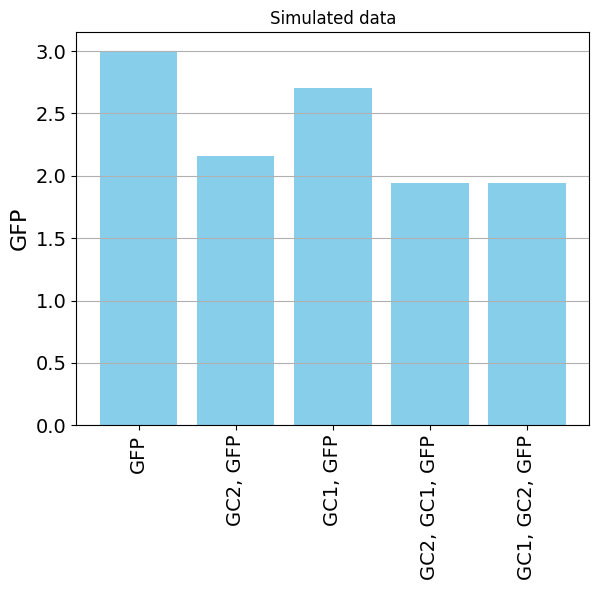

In [ ]:

permutation_gene_labels = ['GC1', 'GC2', 'GFP']  # Replace with actual gene labels

permutations_list = {
    "[3]": [(2,)],
    "[1, 3]": [(0, 2)],
    "[2, 3]": [(1, 2)],
    "[2, 1, 3]": [(1, 0, 2)],
    "[1, 2, 3]": [(0, 1, 2)]
}



sim_values_dict = {
    "[3]": [run_experiment(perm, k_values) for perm in permutations_list["[3]"]],
    "[2, 3]": [run_experiment(perm, k_values) for perm in permutations_list["[2, 3]"]],
    "[1, 3]": [run_experiment(perm, k_values) for perm in permutations_list["[1, 3]"]],
    "[2, 1, 3]": [run_experiment(perm, k_values) for perm in permutations_list["[2, 1, 3]"]],
    "[1, 2, 3]": [run_experiment(perm, k_values) for perm in permutations_list["[1, 2, 3]"]]
}

# Plot the protein concentration of Gene X based on different gene orders
plotExpressionPermutation(permutations_list, permutation_gene_labels, sim_values_dict, color='skyblue', outPath=file_name_figures)


## Saving simulated data

In [ ]:

cassettes = ['1', '2', 'X']  # 1, 2, and 'X' represent actual cassette types... Should be for num_cassettes?

all_combinations = list(product(cassettes + [None], repeat=3))  # `None` represents an empty slot


values_dict = {}

# Run the experiment for all combinations and store the results
for comb in all_combinations:
    # Remove None values for running the experiment
    filtered_comb = [gene for gene in comb if gene is not None]
    values_dict[tuple(filtered_comb)] = run_experiment_permutations(filtered_comb, k_values)



# Define a list to collect data for each combination
data_test = []
# Print the results for each combination with custom formatting
for comb_label, result in values_dict.items():
    # Construct the formatted label, replacing None with '0' to represent empty slots
    formatted_label = ''.join([str(gene) if gene != 'X' else 'X' for gene in comb_label])
    formatted_label = formatted_label.ljust(3, '0')  # Pad with zeros to ensure 3 characters

    print(f"\tCombination {formatted_label}: Total protein concentration of X = {result}")

    # Append the label and result as a dictionary
    data_test.append({"Combination": formatted_label, "Total Protein Concentration of X": result})

# Convert the list into a DataFrame
df_test_results = pd.DataFrame(data_test)

# Display the DataFrame
print(df_test_results)


# Generate the file name based on the first two elements of test_gene_labels
file_name_test = f"%s/X_GC1_GC2_k%0.0fe-2.csv"%(dirNameData, test_k_value*100)

# Define the full output path
output_file_test = os.path.join(pathPARAMS, file_name_test)

# Save the DataFrame to this dynamically generated file path
df_test_results.to_csv(output_file_test, index=False)

print(f"File saved to: {output_file_test}")




	Combination 111: Total protein concentration of X = 0
	Combination 112: Total protein concentration of X = 0
	Combination 11X: Total protein concentration of X = 2.4300000000425217
	Combination 110: Total protein concentration of X = 0
	Combination 121: Total protein concentration of X = 0
	Combination 122: Total protein concentration of X = 0
	Combination 12X: Total protein concentration of X = 1.944000000086275
	Combination 120: Total protein concentration of X = 0
	Combination 1X1: Total protein concentration of X = 2.700000000043567
	Combination 1X2: Total protein concentration of X = 2.700000000043567
	Combination 1XX: Total protein concentration of X = 4.644000000129842
	Combination 1X0: Total protein concentration of X = 2.700000000043567
	Combination 100: Total protein concentration of X = 0
	Combination 211: Total protein concentration of X = 0
	Combination 212: Total protein concentration of X = 0
	Combination 21X: Total protein concentration of X = 1.9440000000865185
	Combi